In [9]:
# Setup scenario
from copy import deepcopy
import json
from pathlib import Path
from time import time

import geopandas as gpd
import fiona
import numpy as np
import pandas as pd
import pycountry
import shapely
from shapely.geometry import Point


from climada.util.api_client import Client
from climada.entity import Entity, Exposures, LitPop
from climada.entity.impact_funcs import ImpactFunc, ImpactFuncSet, ImpfTropCyclone
from climada.hazard import Hazard
from climada.engine import Impact, ImpactCalc
from climada.entity.impact_funcs.storm_europe import ImpfStormEurope
from climada.entity.impact_funcs.trop_cyclone import ImpfSetTropCyclone

import handlers
from handlers import calculate_impact, calculate_impact_function_set, get_exposure_new, get_hazard_new, get_iso3_country_code, get_ref_year
from logger_config import LoggerConfig

logger = LoggerConfig(logger_types=["file"])


notebook_dir = %pwd

# Go up one directory
BASE_DIR = Path(notebook_dir).parent

# Define the paths for exposures and hazards
DATA_DIR = BASE_DIR / "data"
EXPOSURES_DIR = BASE_DIR / "data" / "exposures"
HAZARDS_DIR = BASE_DIR / "data" / "hazards"
REQUIREMENTS_DIR = BASE_DIR / "requirements"
GADM41_EGY_PATH = REQUIREMENTS_DIR / "gadm41_EGY.gpkg"
GADM41_THA_PATH = REQUIREMENTS_DIR / "gadm41_THA.gpkg"
TEMP_DIR = DATA_DIR / "temp" 
ENTITIES_DIR = BASE_DIR / "data" / "entities"

# Available Exposure data types in CLIMADA API for Egypt/Thailand: ['litpop']
# Available Hazard data types in CLIMADA API for Egypt/Thailand: ['river_flood', 'wildfire', 'earthquake', 'flood', 'tropical_cyclone']
# Available climate scenarios for hazard type river_flood/tropical_c in country Egypt/Thailand: ['rcp26', 'historical', 'rcp60', 'rcp85']
# Available time horizons for hazard type river_flood in country Egypt: ['2030_2050', '1980_2000', '2070_2090', '2010_2030', '2050_2070']

country_name = "Egypt"
exposure_type = "litpop"        # Available exposure types for Egypt/Thailand: ['litpop']
hazard_type = "earthquake"     # Available hazard types for Egypt/Thailand: ['river_flood', 'wildfire', 'earthquake', 'flood', 'tropical_cyclone']
climate_scenario = "historical" # Available scenarios for Egypt/Thailand: ['rcp26', 'historical', 'rcp60', 'rcp85']
time_horizon = "2030_2050"      # Available time horizons for Egypt/Thailand: ['2030_2050', '1980_2000', '2070_2090', '2010_2030', '2050_2070'] / 
annual_growth = 1.01

client = Client()

In [2]:
# List DataTypeInfos
data_type_infos = client.list_data_type_infos()
exposure_data_types = [
    data_type_info.data_type for data_type_info in data_type_infos if data_type_info.data_type_group == 'exposures']
hazard_data_types = [
    data_type_info.data_type for data_type_info in data_type_infos if data_type_info.data_type_group == 'hazard']

print(
    f'Available Exposure data types in CLIMADA API for all countries:\n{exposure_data_types}')
print(
    f'Available Hazard data types in CLIMADA API for all countries:\n{hazard_data_types}')

Available Exposure data types in CLIMADA API for all countries:
['litpop', 'crop_production', 'crops']
Available Hazard data types in CLIMADA API for all countries:
['tropical_cyclone', 'wildfire', 'river_flood', 'storm_europe', 'relative_cropyield', 'earthquake', 'flood', 'hail']


In [3]:
# Available country Exposures and Hazard data types
dataset_infos = client.list_dataset_infos(
    properties={
        'country_name': country_name,
    }
)

exposure_data_types = list(set(
    [dataset_info.data_type.data_type for dataset_info in dataset_infos if dataset_info.data_type.data_type_group == 'exposures']))
hazard_data_types = list(set(
    [dataset_info.data_type.data_type for dataset_info in dataset_infos if dataset_info.data_type.data_type_group == 'hazard']))

print(
    f'Available Exposure data types in CLIMADA API for {country_name}: {exposure_data_types}')
print(
    f'Available Hazard data types in CLIMADA API for {country_name}: {hazard_data_types}')

Available Exposure data types in CLIMADA API for Egypt: ['litpop']
Available Hazard data types in CLIMADA API for Egypt: ['river_flood', 'tropical_cyclone', 'wildfire', 'flood', 'earthquake']


In [ ]:
if hazard_type == 'river_flood' or 'wildfire':
    available_scenarios = list(set([dataset_info.properties['climate_scenario']
                               for dataset_info in dataset_infos if dataset_info.data_type.data_type == hazard_type]))
    available_time_horizons = list(set([dataset_info.properties['year_range']
                                   for dataset_info in dataset_infos if dataset_info.data_type.data_type == hazard_type]))
if hazard_type == 'tropical_cyclone':
    available_scenarios = list(set([dataset_info.properties['climate_scenario']
                               for dataset_info in dataset_infos if dataset_info.data_type.data_type == hazard_type]))
    available_time_horizons = list(set([dataset_info.properties.get(
        'ref_year') for dataset_info in dataset_infos if dataset_info.data_type.data_type == hazard_type]))
if hazard_type == 'earthquake':
    available_scenarios = []
    available_time_horizons = []
if hazard_type == 'flood':
    available_scenarios = []
    available_time_horizons = list(set([dataset_info.properties['year_range']
                                   for dataset_info in dataset_infos if dataset_info.data_type.data_type == hazard_type]))

print(
    f'Available climate scenarios for hazard type {hazard_type} in country {country_name}: {available_scenarios}')
print(
    f'Available time horizons for hazard type {hazard_type} in country {country_name}: {available_time_horizons}')

In [11]:
# Available country Hazard DatasetInfos
hazard_dataset_infos = client.list_dataset_infos(
    properties={
        "data_type": hazard_type,
        "country_name": country_name,
        # "climate_scenario": climate_scenario,
    }
)
hazard_dataset_infos

[DatasetInfo(uuid='508648f4-c242-441f-9ed9-904431c9b92f', data_type=DataTypeShortInfo(data_type='earthquake', data_type_group='hazard'), name='earthquake_hist_above4_818', version='v1.1', status='active', properties={'res_arcsec': '150', 'event_type': 'observed', 'spatial_coverage': 'country', 'country_iso3alpha': 'EGY', 'country_name': 'Egypt', 'country_iso3num': '818'}, files=[FileInfo(uuid='508648f4-c242-441f-9ed9-904431c9b92f', url='https://data.iac.ethz.ch/climada/40e86fb1-873b-45fb-91a8-04f1d97e76b2/earthquake_hist_above4_818.hdf5', file_name='earthquake_hist_above4_818.hdf5', file_format='hdf5', file_size=5365381, check_sum='md5:863bcd1e85990670c785f4859c3708a5')], doi=None, description='Global earthquake hazard set at 4km resolution, \nbased on USGS epicentres database and a \nsimple probabilistic sampling starting from the historic earthquake catalog,\nwith 9 synthetic events per historic record.', license='Attribution 4.0 International (CC-BY-4.0)', activation_date='2023-01-3

In [17]:
# Get Exposure and Exposure gdf
# Available Exposures: ['litpop']
exposure = get_exposure_new(country=country_name)
exposure_gdf = exposure.gdf
# exposure_gdf

In [18]:
# Get Hazard
# Available Hazards: ['river_flood', 'tropical_cyclone', 'wildfire', 'flood', 'earthquake']
hazard = get_hazard_new(
    hazard_type=hazard_type,
    scenario=climate_scenario,
    time_horizon=time_horizon,
    country=country_name,
)

In [5]:
# Get Impact
impact_function_set = calculate_impact_function_set(
    hazard=hazard, impact_function_name="Flood Africa JRC Residential"
)
impact = calculate_impact(exposure, hazard, impact_function_set)

2023-12-09 17:11:27,009 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 17378 coordinates.


In [6]:
# ENTITY_FILE_PATH = ENTITIES_DIR / "entity_template.xlsx"
ENTITY_FILE_PATH = Path("C:\\Users\\gkalomalos\\Projects\\unu\\climada_python\\climada\\data\\demo\\demo_today.xlsx")
entity = Entity.from_excel(ENTITIES_DIR)
entity

PermissionError: [Errno 13] Permission denied: 'c:\\Users\\gkalomalos\\Projects\\unu\\climada-unu\\data\\entities'

In [23]:
from climada.util.constants import ENT_TEMPLATE_XLS
ent = Entity.from_excel(ENT_TEMPLATE_XLS)
imp = ImpactCalc(
    ent.exposures, 
    ent.impact_funcs,
    hazard
).impact()

2023-12-09 18:46:06,487 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 24 coordinates.
2023-12-09 18:46:06,487 - climada.engine.impact_calc - WARNING - No exposures with value >0 in the vicinity of the hazard.


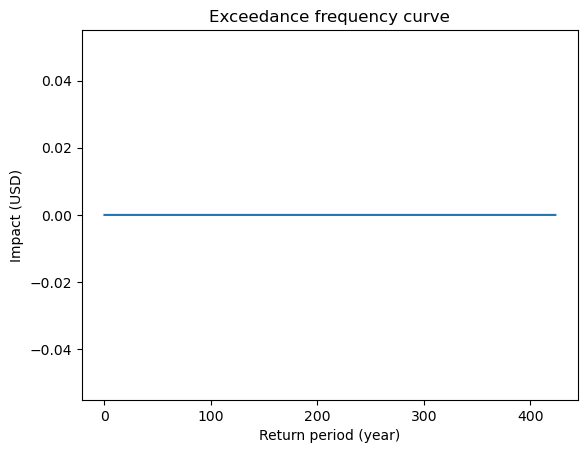

In [25]:
# imp.plot_rp_imp((25,))
freq_curve = imp.calc_freq_curve() # impact exceedance frequency curve
freq_curve.plot();


array([[<AxesSubplot:title={'center':'TC 1: Tropical cyclone default'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>,
        <AxesSubplot:title={'center':'TC 3: TC Building code'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>],
       [<AxesSubplot:title={'center':'TS 1: Surge default'}, xlabel='Intensity (m)', ylabel='Impact (%)'>,
        <AxesSubplot:title={'center':'WS 1: Wind default'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>],
       [<AxesSubplot:title={'center':'EQ 1: Earthquake default'}, xlabel='Intensity (MMI)', ylabel='Impact (%)'>,
        <AxesSubplot:title={'center':'VQ 1: Volcano default'}, xlabel='Intensity (cm)', ylabel='Impact (%)'>],
       [<AxesSubplot:title={'center':'TR 1: Tropical rain default'}, xlabel='Intensity (mm)', ylabel='Impact (%)'>,
        <AxesSubplot:title={'center':'LS 1: Landslide default'}, xlabel='Intensity (m/m)', ylabel='Impact (%)'>],
       [<AxesSubplot:title={'center':'FL 1: Flood default'}, xlabel='Intensity (m)', ylabel='Imp

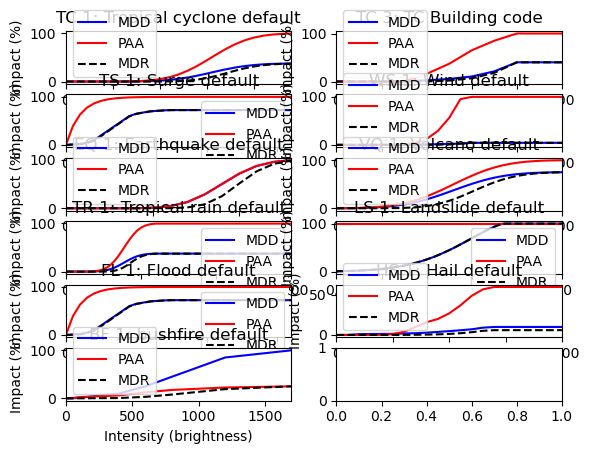

In [16]:
ent.impact_funcs.plot()